# Model 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib


In [5]:
# Step 1: Load Data
train_file = '/content/sample_data/data/train_data.xlsx'  # Update with actual file name
test_file = '/content/sample_data/data/test_data.xlsx'    # Update with actual file name

train_data = pd.read_excel(train_file)
test_data = pd.read_excel(test_file)

In [6]:
# Step 2: Exploratory Data Analysis (EDA)
# Basic Info
print("Training Data Overview:")
print(train_data.info())
print("\nTest Data Overview:")
print(test_data.info())

Training Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113705 entries, 0 to 113704
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   customer_id          113705 non-null  int64         
 1   transaction_date     113705 non-null  datetime64[ns]
 2   sub_grade            113705 non-null  object        
 3   term                 113705 non-null  object        
 4   home_ownership       113705 non-null  object        
 5   cibil_score          113705 non-null  int64         
 6   total_no_of_acc      113705 non-null  int64         
 7   annual_inc           113705 non-null  float64       
 8   int_rate             113705 non-null  float64       
 9   purpose              113705 non-null  object        
 10  loan_amnt            113705 non-null  int64         
 11  application_type     113705 non-null  object        
 12  installment          113705 non-null  float64   

In [7]:
# Checking for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())


Missing Values in Training Data:
customer_id            0
transaction_date       0
sub_grade              0
term                   0
home_ownership         0
cibil_score            0
total_no_of_acc        0
annual_inc             0
int_rate               0
purpose                0
loan_amnt              0
application_type       0
installment            0
verification_status    0
account_bal            0
emp_length             0
loan_status            0
dtype: int64


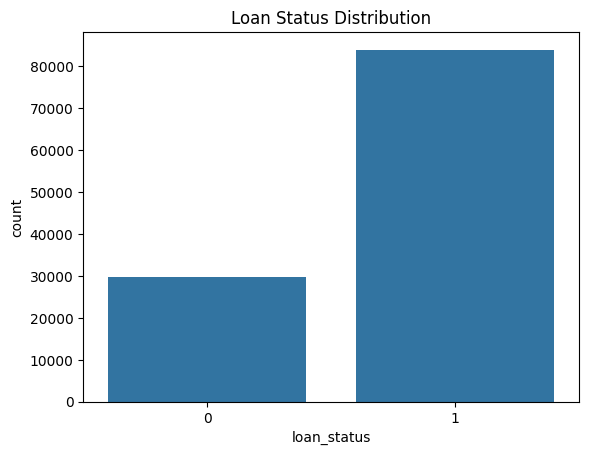

In [8]:
# Target Variable Distribution
if 'loan_status' in train_data.columns:
    sns.countplot(x='loan_status', data=train_data)
    plt.title('Loan Status Distribution')
    plt.show()
else:
    print("Error: 'loan_status' column not found in the dataset.")

In [9]:
# Step 3: Data Preprocessing
# Handle missing values
train_data.fillna(train_data.median(numeric_only=True), inplace=True)
test_data.fillna(test_data.median(numeric_only=True), inplace=True)

# Encode categorical variables
categorical_cols = train_data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on the combined unique values from both train and test data
    le.fit(pd.concat([train_data[col], test_data[col]], ignore_index=True).astype(str).unique())
    train_data[col] = le.transform(train_data[col].astype(str))
    if col in test_data.columns:
        test_data[col] = le.transform(test_data[col].astype(str))
    label_encoders[col] = le

In [10]:
# Feature Engineering
# Convert transaction_date to datetime and extract features
for df in [train_data, test_data]:
    if 'transaction_date' in df.columns:
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        df['transaction_month'] = df['transaction_date'].dt.month
        df['days_since_transaction'] = (pd.Timestamp.now() - df['transaction_date']).dt.days
        df.drop('transaction_date', axis=1, inplace=True)

# Create debt-to-income ratio
for df in [train_data, test_data]:
    if 'loan_amnt' in df.columns and 'annual_inc' in df.columns:
        df['debt_to_income'] = df['loan_amnt'] / (df['annual_inc'] + 1e-6)

In [11]:
# Separate features and target
X = train_data.drop(columns=['loan_status', 'customer_id'])
y = train_data['loan_status']

# Step 4: Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Split data
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [12]:
# Step 6: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [13]:
# Step 7: Model Building
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [14]:
# Step 8: Model Evaluation
val_predictions = rf_model.predict(X_val_scaled)
print("Classification Report:\n", classification_report(y_val, val_predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82     16996
           1       0.80      0.86      0.83     16611

    accuracy                           0.82     33607
   macro avg       0.82      0.82      0.82     33607
weighted avg       0.83      0.82      0.82     33607



In [15]:
# ROC-AUC
roc_auc = roc_auc_score(y_val, rf_model.predict_proba(X_val_scaled)[:, 1])
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.8979148245230857


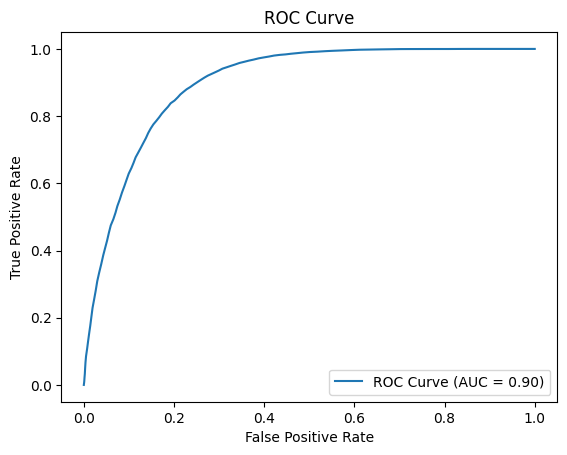

In [16]:
fpr, tpr, _ = roc_curve(y_val, rf_model.predict_proba(X_val_scaled)[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [19]:
# Step 9: Test Set Evaluation
# Check if 'loan_status' exists, if not, try 'default' or the correct column name
target_column = 'loan_status'  # Assume 'loan_status' is the target column
if target_column not in test_data.columns:
    target_column = 'default'  # Try 'default' as the target column
    if target_column not in test_data.columns:
        # If neither 'loan_status' nor 'default' is found, you'll need to
        # identify the correct target column name from your test_data DataFrame.
        # Once you have the correct name, assign it to 'target_column'.
        print(f"Error: Neither 'loan_status' nor 'default' found in the test dataset columns: {test_data.columns.tolist()}")
        target_column = input("Please enter the correct target column name: ")  # Get correct column name

test_X = test_data.drop(columns=[target_column])
test_y = test_data[target_column]
test_X = test_data.drop(columns=[target_column, 'customer_id'])  # Drop 'customer_id' here

test_X_scaled = scaler.transform(test_X)
test_predictions = rf_model.predict(test_X_scaled)

In [20]:
print("Test Set Classification Report:\n", classification_report(test_y, test_predictions))

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.67      0.53      3055
           1       0.73      0.52      0.61      5400

    accuracy                           0.57      8455
   macro avg       0.59      0.59      0.57      8455
weighted avg       0.63      0.57      0.58      8455



# Model 2

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import joblib

In [22]:
# Step 1: Load Data
train_file = '/content/sample_data/data/train_data.xlsx'  # Update with actual file name
test_file = '/content/sample_data/data/test_data.xlsx'    # Update with actual file name

train_data = pd.read_excel(train_file)
test_data = pd.read_excel(test_file)

In [23]:
# Step 2: Exploratory Data Analysis (EDA)
# Basic Info
print("Training Data Overview:")
print(train_data.info())
print("\nTest Data Overview:")
print(test_data.info())

Training Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113705 entries, 0 to 113704
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   customer_id          113705 non-null  int64         
 1   transaction_date     113705 non-null  datetime64[ns]
 2   sub_grade            113705 non-null  object        
 3   term                 113705 non-null  object        
 4   home_ownership       113705 non-null  object        
 5   cibil_score          113705 non-null  int64         
 6   total_no_of_acc      113705 non-null  int64         
 7   annual_inc           113705 non-null  float64       
 8   int_rate             113705 non-null  float64       
 9   purpose              113705 non-null  object        
 10  loan_amnt            113705 non-null  int64         
 11  application_type     113705 non-null  object        
 12  installment          113705 non-null  float64   

In [24]:
# Checking for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())


Missing Values in Training Data:
customer_id            0
transaction_date       0
sub_grade              0
term                   0
home_ownership         0
cibil_score            0
total_no_of_acc        0
annual_inc             0
int_rate               0
purpose                0
loan_amnt              0
application_type       0
installment            0
verification_status    0
account_bal            0
emp_length             0
loan_status            0
dtype: int64


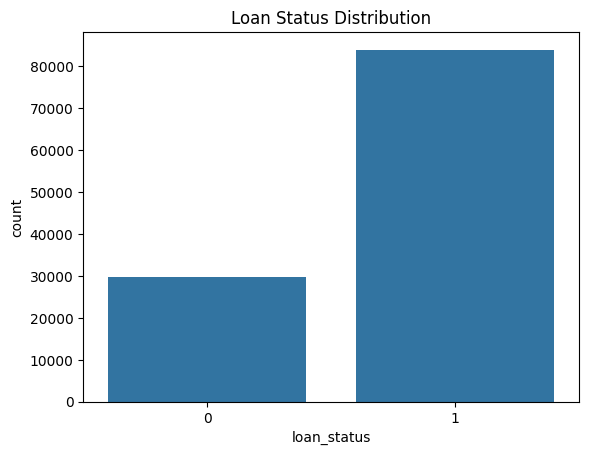

In [25]:
# Target Variable Distribution
if 'loan_status' in train_data.columns:
    sns.countplot(x='loan_status', data=train_data)
    plt.title('Loan Status Distribution')
    plt.show()
else:
    print("Error: 'loan_status' column not found in the dataset.")

In [26]:
# Step 3: Data Preprocessing
# Handle missing values
train_data.fillna(train_data.median(numeric_only=True), inplace=True)
test_data.fillna(test_data.median(numeric_only=True), inplace=True)

In [27]:
# Encode categorical variables
categorical_cols = train_data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on the combined unique values from both train and test data
    le.fit(pd.concat([train_data[col], test_data[col]], ignore_index=True).astype(str).unique())
    train_data[col] = le.transform(train_data[col].astype(str))
    # Check if the column exists in test_data before transforming
    if col in test_data.columns:
        # Handle unknown values in test data
        test_data[col] = test_data[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le

In [28]:
# Feature Engineering
# Convert transaction_date to datetime and extract features
for df in [train_data, test_data]:
    if 'transaction_date' in df.columns:
        df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        df['transaction_month'] = df['transaction_date'].dt.month
        df['days_since_transaction'] = (pd.Timestamp.now() - df['transaction_date']).dt.days
        df.drop('transaction_date', axis=1, inplace=True)

In [29]:
# Create debt-to-income ratio
for df in [train_data, test_data]:
    if 'loan_amnt' in df.columns and 'annual_inc' in df.columns:
        df['debt_to_income'] = df['loan_amnt'] / (df['annual_inc'] + 1e-6)

In [30]:
# Separate features and target
X = train_data.drop(columns=['loan_status', 'customer_id'])
y = train_data['loan_status']

In [31]:
# Step 4: Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [32]:
# Step 5: Split data
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 6: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [33]:
# Step 7: Model Building with XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [34]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:40:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [35]:
# Best Model
best_xgb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [36]:
# Step 8: Model Evaluation
val_predictions = best_xgb_model.predict(X_val_scaled)
print("Classification Report:\n", classification_report(y_val, val_predictions))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.76      0.83     16996
           1       0.79      0.91      0.85     16611

    accuracy                           0.84     33607
   macro avg       0.84      0.84      0.84     33607
weighted avg       0.84      0.84      0.84     33607



In [37]:
# ROC-AUC
roc_auc = roc_auc_score(y_val, best_xgb_model.predict_proba(X_val_scaled)[:, 1])
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.9069315501773098


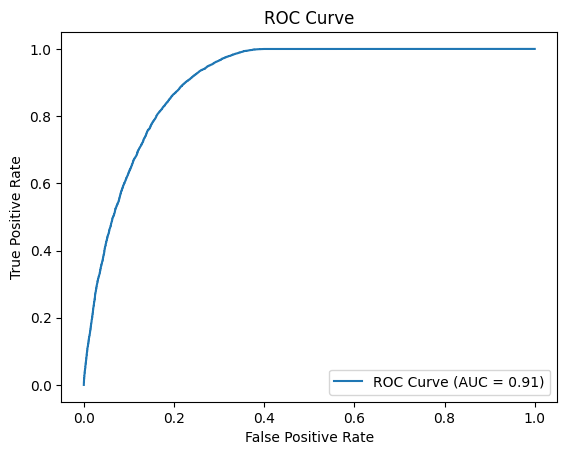

In [38]:
fpr, tpr, _ = roc_curve(y_val, best_xgb_model.predict_proba(X_val_scaled)[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [39]:
# Step 9: Test Set Evaluation
if 'loan_status' in test_data.columns:
    test_X = test_data.drop(columns=['loan_status', 'customer_id'])
    test_y = test_data['loan_status']
else:
    test_X = test_data.drop(columns=['customer_id'])
    test_y = None

In [40]:
# Scale test set
test_X_scaled = scaler.transform(test_X)

test_predictions = best_xgb_model.predict(test_X_scaled)
if test_y is not None:
    print("Test Set Classification Report:\n", classification_report(test_y, test_predictions))

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.99      0.54      3055
           1       0.86      0.05      0.09      5400

    accuracy                           0.39      8455
   macro avg       0.61      0.52      0.32      8455
weighted avg       0.68      0.39      0.25      8455

